# Análisis de datos del negocio de taxis

## Tabla de contenidos

* [Introducción](#intro) 
* [Objetivos](#objetivos)
* [Preprocesamiento de  datos](#data_review)
* [Análisis exploratorio de datos](#EDA)
* [Prueba de hipótesis](#hypotheses)
* [Conclusiones](#end)

## Introducción<a id='intro'></a>

En este proyecto se investigará el comportamiento de los recorridos en taxis en la ciudad de Chicago. Se prestará especial atención a la influencia de factores climáticos en la dinámica del negocio.      

## Objetivos<a id='objetivos'></a>

* Identificar los barrios en los que finalizan más recorridos de taxi (los diez principales).
* Probar una hipótesis sobre la influencia del tiempo atmosférico en la duración de los viajes.

## Preprocesamiento de datos<a id='data_review'></a>

In [183]:
# Importa liberías

import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt

In [184]:
# Carga de datos

trips_amount = pd.read_csv("/datasets/project_sql_result_01.csv")
location_and_trips = pd.read_csv("/datasets/project_sql_result_04.csv")
loop_to_airport = pd.read_csv("/datasets/project_sql_result_07.csv")

In [185]:
trips_amount.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [186]:
trips_amount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


Para esta primera tabla no es necesario realizar ningún preprocesamiento.

In [187]:
location_and_trips.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [188]:
location_and_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


En es caso, conviene transformar el tipo de datos del campo "average_trips" de flotante a entero, pues no existen fracciones de viaje.  

In [189]:
location_and_trips["average_trips"] = location_and_trips["average_trips"].astype('int')
location_and_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dropoff_location_name  94 non-null     object
 1   average_trips          94 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [190]:
loop_to_airport.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [191]:
loop_to_airport["weather_conditions"].unique()

array(['Good', 'Bad'], dtype=object)

In [192]:
loop_to_airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


En este caso, es preferible transformar los datos de fechas al tipo de dato correspondiente de python. El campo duración en segundos, es tan también recomendable pasarlo de "float" a "integer". 

In [193]:
loop_to_airport["duration_seconds"] = loop_to_airport["duration_seconds"].astype('int')
loop_to_airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   start_ts            1068 non-null   object
 1   weather_conditions  1068 non-null   object
 2   duration_seconds    1068 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 25.2+ KB


In [194]:
loop_to_airport["start_ts"] = pd.to_datetime(loop_to_airport["start_ts"], errors='coerce')
loop_to_airport["start_ts"] = loop_to_airport["start_ts"].dt.date
loop_to_airport["start_ts"] = pd.to_datetime(loop_to_airport["start_ts"], errors='coerce')
loop_to_airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            1068 non-null   datetime64[ns]
 1   weather_conditions  1068 non-null   object        
 2   duration_seconds    1068 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 25.2+ KB


In [195]:
loop_to_airport.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25,Good,2410
1,2017-11-25,Good,1920
2,2017-11-25,Good,1543
3,2017-11-04,Good,2512
4,2017-11-11,Good,1440


**Conclusiones preprocesamiento de datos**

1. Los datos provistos por las consultas SQL se encontraron prácticamente limpios. Los mismos requirieron preprocesamientos sencillos como la conversión de tipo de datos o el truncar datos de fecha y hora a exclusivamente fecha. 

## Análisis exploratorio de datos

En primer lugar se investigará cuales fueron los barrios con más finalizaciones de recorridos.

In [196]:
main_location_and_trips = location_and_trips.sort_values(by='average_trips', ascending=False).head(10)
main_location_and_trips

,dropoff_location_name,average_trips
0,Loop,10727
1,River North,9523
2,Streeterville,6664
3,West Loop,5163
4,O'Hare,2546
5,Lake View,2420
6,Grant Park,2068
7,Museum Campus,1510
8,Gold Coast,1364
9,Sheffield & DePaul,1259


Text(0, 0.5, 'Average number of trips')

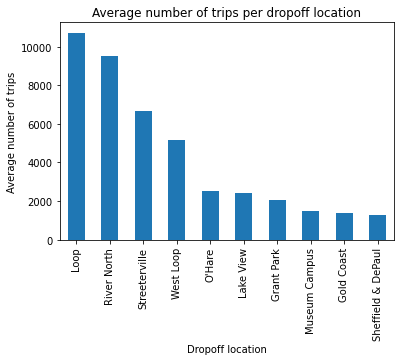

In [197]:
main_location_and_trips.plot.bar(x="dropoff_location_name", y="average_trips", legend=False)
plt.title("Average number of trips per dropoff location")
plt.xlabel("Dropoff location")
plt.ylabel("Average number of trips")

**Conclusiones análisis exploratorio de datos**

1. Los barrios de Chicago en los que se culminaron la mayor cantidades de viajes en noviembre de 2017 fueron: 1) Loop, 2) River North y 3) Streeterville. 

## Prueba de hipótesis

En esta sección se probarán dos hipótesis:

h0: La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare es igual los sábados lluviosos que los sábados no lluviosos
h1: La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados lluviosos

En primer lugar, comprobaremos si las fechas corresponden exclusivamente a días sábados.

In [198]:
loop_to_airport['start_ts_day'] = loop_to_airport['start_ts'].dt.dayofweek
loop_to_airport['start_ts_day'].unique()

array([5])

Efectivamente, las fechas solo corresponden a días sábados. Ahora, podemos continuar con el análisis. 

In [199]:
loop_to_airport.head(10)

,start_ts,weather_conditions,duration_seconds,start_ts_day
0,2017-11-25,Good,2410,5
1,2017-11-25,Good,1920,5
2,2017-11-25,Good,1543,5
3,2017-11-04,Good,2512,5
4,2017-11-11,Good,1440,5
5,2017-11-11,Good,1320,5
6,2017-11-04,Bad,2969,5
7,2017-11-18,Good,2280,5
8,2017-11-11,Good,2460,5
9,2017-11-11,Good,2040,5


In [200]:
# Extracción de datos para la pruba de hipótesis

good_weather = loop_to_airport[loop_to_airport['weather_conditions'] == "Good"]
duration_good_weather = good_weather['duration_seconds']
bad_weather = loop_to_airport[loop_to_airport['weather_conditions'] == "Bad"]
duration_bad_weather = bad_weather['duration_seconds']

In [201]:
# Prueba de hipótesis

alpha = 0.05 # el nivel de significancia estadística crítica
# si el valor p es menor que alfa, rechazamos la hipótesis

results = st.ttest_ind(duration_good_weather, duration_bad_weather)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

p-value:  6.517970327099473e-12
Rechazamos la hipótesis nula


## Conclusiones

1. Los datos provistos por las consultas SQL se encontraron prácticamente limpios. Los mismos requirieron preprocesamientos sencillos como la conversión de tipo de datos o el truncar datos de fecha y hora a exclusivamente fecha.
2. Los barrios de Chicago en los que se culminaron la mayor cantidades de viajes en noviembre de 2017 fueron: 1) Loop, 2) River North y 3) Streeterville
3. De conformidad con los resultados de la prueba de hipótesis, se concluye que lo más probable es que efectivamente la duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados lluviosos.